## Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smformula
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load the combined dataset and inspect it

In [2]:
os.chdir('C:\Apurva\Conservation Games\Games meta-analysis\Datasets\Data Gabon, Orkney, Madagascar and Kenya')
print(os.getcwd())

C:\Apurva\Conservation Games\Games meta-analysis\Datasets\Data Gabon, Orkney, Madagascar and Kenya


#### Drop rows where envProduction is NaN

In [3]:
# print number of rows in the dataset
data = pd.read_csv('combined4.csv', index_col=0)
print(len(data))
# drop rows where envProduction is NaN 
data.dropna(subset=['envProduction'], inplace=True)
print(len(data))

9243
6511


## Compute group statistics (mean, variance, min, max)

In [4]:
for col in ['Age', 'Education', 'Gender', 'primary_farming', 'secondary_farming']:
    data[col+'_mean'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].mean(axis=1)
    data[col+'_var'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].var(axis=1, ddof=0)

#### One-hot encode the country column

In [5]:
# Get one hot encoding of country column
one_hot = pd.get_dummies(data['country'])
# Join the encoded dataframe
data = pd.concat([data, one_hot], axis=1)

#### Verify if grouping by GameID and Treatments would collapse the rounds to unique game level

In [6]:
print(data['Rounds'].unique())
print(data.groupby(['GameID', 'Treatments']).transform('nunique')['Rounds'].unique())

[ 1  2  3  4  5  6  7  8  9 10]
[ 7  6  8  5  9 10]


#### Get group-wise variance in environmental production outcome

In [7]:
data['varEnvProduction'] = data.groupby(['GameID', 'Treatments'])['envProduction'].transform('var')

## Compute column-wise z-scores (separately for every subset of dataset)

In [8]:
col_list = ['Age_mean', 'Age_var', 'Education_mean', 'Education_var', 'Gender_mean', 'Gender_var', 
            'primary_farming_mean', 'primary_farming_var', 'secondary_farming_mean', 'secondary_farming_var', 'varEnvProduction']
for col in col_list:
    data['z_'+col] = data.groupby('country')[col].transform(lambda x: scale(x.astype(float)))

In [9]:
# define explanatory and response variables
explanatory_var = ['z_' + x for x in ['Age_mean', 'Age_var', 'Education_mean', 'Education_var', 'Gender_mean', 'Gender_var', 
                                      'primary_farming_mean', 'primary_farming_var', 'secondary_farming_mean', 'secondary_farming_var']] + ['gabon', 'orkney', 'tanzania', 'MAD', 'KEN']

response_var = 'z_varEnvProduction'

## Collapse data at unique game level

In [10]:
data = data.groupby(['GameID', 'Treatments']).first().reset_index()

#### Box-plots showing country-wise distribution of the variation in environmental production outcome

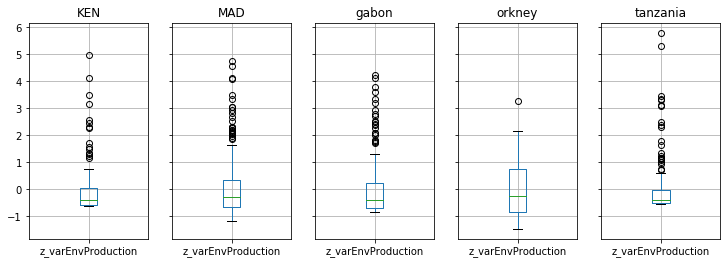

In [11]:
data[['z_varEnvProduction', 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,5))
plt.show()

## Correlation heat-map for explanatory variables

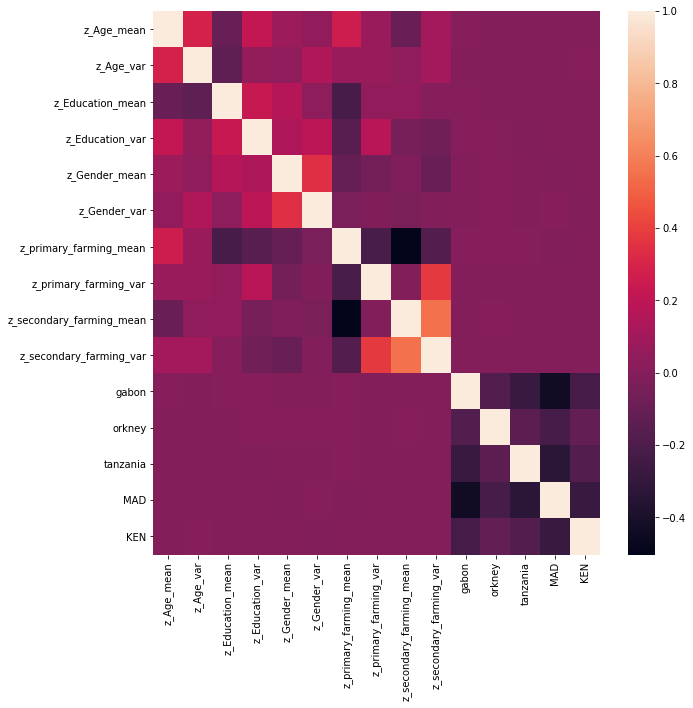

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data[explanatory_var].corr(), ax=ax)

#### Correlation between explanatory variables and response variable

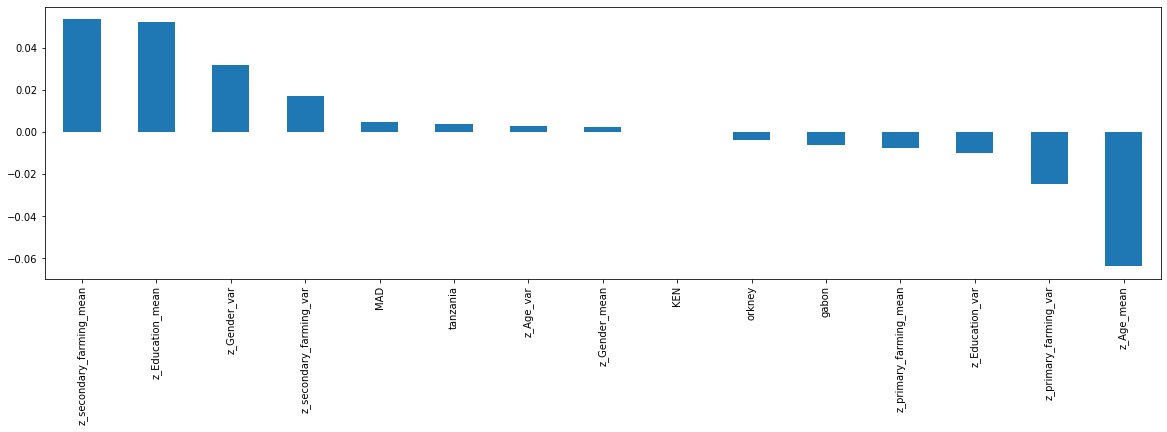

In [13]:
data[explanatory_var+[response_var]].corr()[response_var].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(20,5))

In [14]:
data[explanatory_var].corr().unstack().sort_values(ascending=False)[len(explanatory_var):]

z_secondary_farming_var   z_secondary_farming_mean    0.548174
z_secondary_farming_mean  z_secondary_farming_var     0.548174
z_primary_farming_var     z_secondary_farming_var     0.382450
z_secondary_farming_var   z_primary_farming_var       0.382450
z_Gender_mean             z_Gender_var                0.346422
                                                        ...   
tanzania                  MAD                        -0.336470
MAD                       gabon                      -0.437154
gabon                     MAD                        -0.437154
z_secondary_farming_mean  z_primary_farming_mean     -0.503036
z_primary_farming_mean    z_secondary_farming_mean   -0.503036
Length: 210, dtype: float64

## OLS regression analysis

In [15]:
# drop duplicate rows
print(len(data))
data.drop_duplicates(inplace=True)
print(len(data))

978
978


In [16]:
# write formula
formula = response_var + ' ~ '
for var in explanatory_var:
    formula += var + ' + '
formula = formula[:-3]

In [17]:
# define and fit model
model = smformula.ols(formula, data=data)
results = model.fit(cov_type='cluster', cov_kwds={'groups': data['GameID']})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     z_varEnvProduction   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5843
Date:                Mon, 05 Apr 2021   Prob (F-statistic):              0.885
Time:                        01:50:47   Log-Likelihood:                -1380.6
No. Observations:                 978   AIC:                             2791.
Df Residuals:                     963   BIC:                             2864.
Df Model:                          14                                         
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### ANOVA table (F-statistic and p-value)

In [18]:
table = sm.stats.anova_lm(results, typ=2) # Type 2 ANOVA DataFrame
print(table)

                              sum_sq     df         F    PR(>F)
z_Age_mean                  2.558476    1.0  2.556299  0.111284
z_Age_var                   0.242709    1.0  0.242503  0.622893
z_Education_mean            1.886229    1.0  1.884624  0.171201
z_Education_var             0.001604    1.0  0.001603  0.968100
z_Gender_mean               0.038829    1.0  0.038795  0.844035
z_Gender_var                0.793281    1.0  0.792606  0.374281
z_primary_farming_mean      1.286220    1.0  1.285126  0.258176
z_primary_farming_var       0.024057    1.0  0.024036  0.876935
z_secondary_farming_mean    2.028076    1.0  2.026350  0.156002
z_secondary_farming_var     0.038261    1.0  0.038229  0.845165
gabon                       0.013670    1.0  0.013658  0.907070
orkney                      0.010692    1.0  0.010683  0.917774
tanzania                    0.014480    1.0  0.014468  0.904369
MAD                         0.016746    1.0  0.016732  0.897197
KEN                         0.000183    

## Visualizing coefficients and beta coefficients

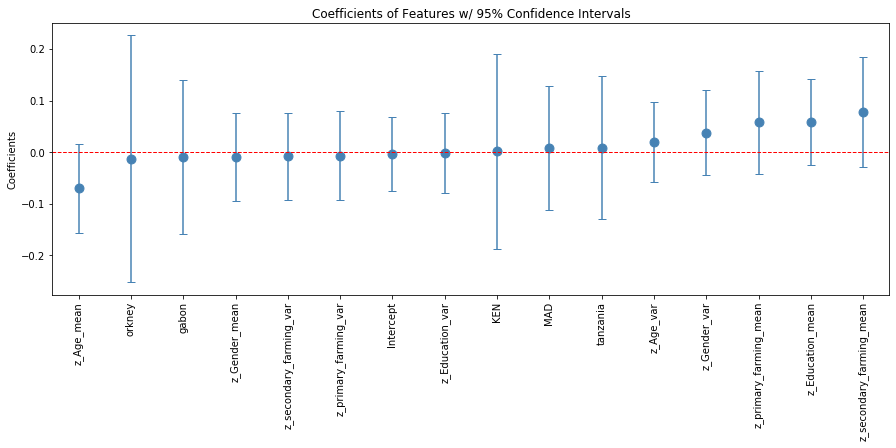

In [19]:
# Create dataframe of results summary 
coef_df = pd.DataFrame(results.summary().tables[1].data)
# Add column names
coef_df.columns = coef_df.iloc[0]
# Drop the extra row with column labels
coef_df=coef_df.drop(0)
# Set index to variable names 
coef_df = coef_df.set_index(coef_df.columns[0])
# Change datatype from object to float
coef_df = coef_df.astype(float)
# Get errors; (coef - lower bound of conf interval)
errors = coef_df['coef'] - coef_df['[0.025']
# Append errors column to dataframe
coef_df['errors'] = errors
# Sort values by coef ascending
coef_df = coef_df.sort_values(by=['coef'])
# Plot Coefficients
# x-labels
variables = list(coef_df.index.values)
# Add variables column to dataframe
coef_df['variables'] = variables
# Set sns plot style back to 'poster'
# This will make bars wide on plot
# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(15,5))
# Error bars for 95% confidence interval
# Can increase capsize to add whiskers
coef_df.plot(x='variables', y='coef', kind='bar',
             ax=ax, color='none', 
             ecolor='steelblue',capsize=4,
             yerr='errors', legend=False)
# Set title & labels
plt.title('Coefficients of Features w/ 95% Confidence Intervals')
ax.set_ylabel('Coefficients')
ax.set_xlabel('')
# Coefficients
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='o', s=80, 
           y=coef_df['coef'], color='steelblue')

# Line to define zero on the y-axis
ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
plt.show()

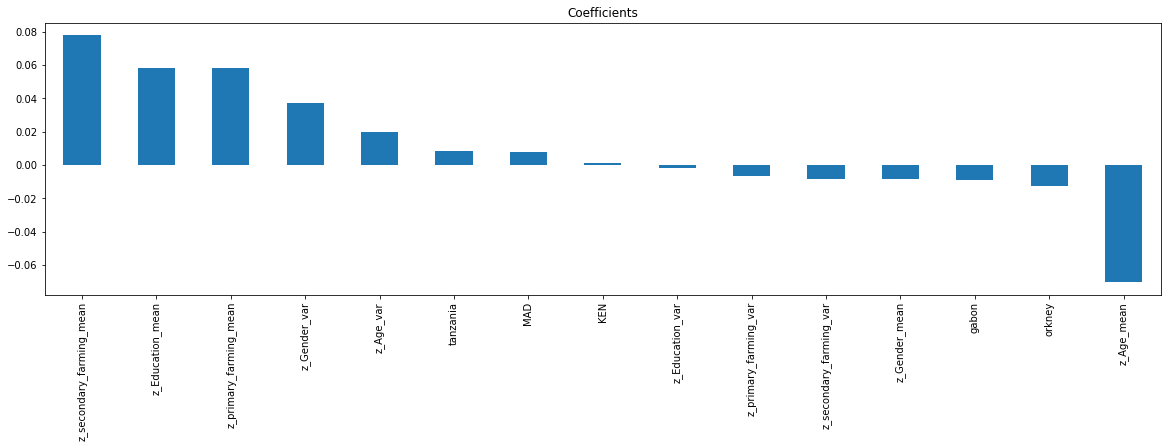

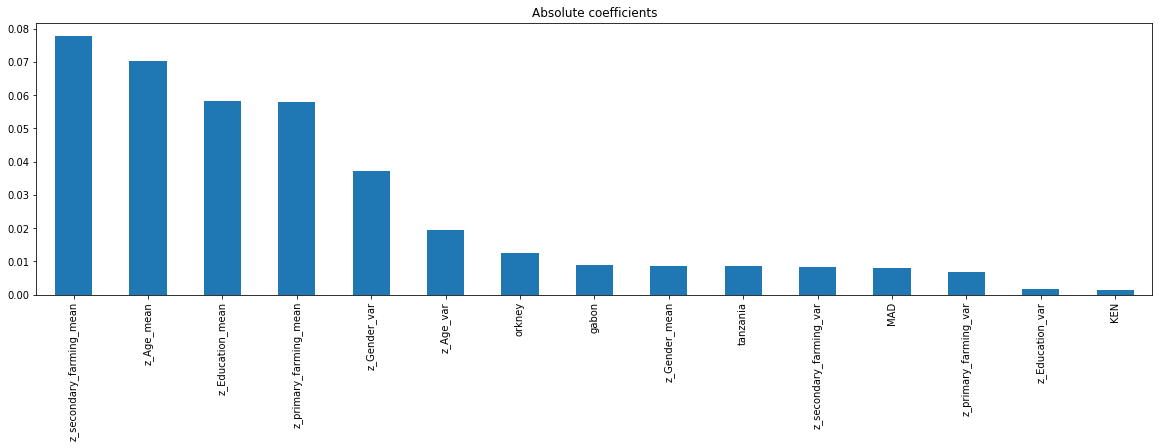

In [20]:
# plot coefficients
plt.figure(figsize=(20,5))
plt.title('Coefficients')
results.params.iloc[1:].sort_values(ascending=False).plot(kind='bar')
plt.show()

# plot absolute coefficients
plt.figure(figsize=(20,5))
plt.title('Absolute coefficients')
results.params.iloc[1:].abs().sort_values(ascending=False).plot(kind='bar')
plt.show()

## Heteroscedasticity Plot

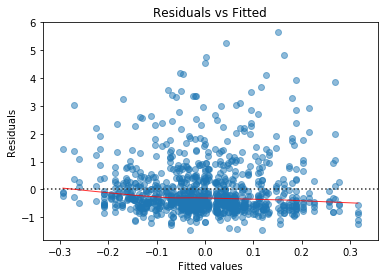

In [21]:
# model fitted values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = results.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = results.get_influence().cooks_distance[0]
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, data[response_var], data=data[explanatory_var],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

## Reduction in R2 if a variable is removed

In [22]:
orig_r2 = results.rsquared
for var in explanatory_var:
    temp_explanatory_var = explanatory_var.copy()
    temp_explanatory_var.remove(var)
    formula = response_var + ' ~ '
    for temp_var in temp_explanatory_var:
        formula += temp_var + ' + '
    formula = formula[:-3]
    temp_model = smformula.ols(formula, data=data).fit()
    print(var, temp_model.rsquared-results.rsquared)

z_Age_mean -0.003782241823193311
z_Age_var -0.00033608366930892863
z_Education_mean -0.0029200014157857446
z_Education_var -1.935348894144262e-06
z_Gender_mean -6.024972190066258e-05
z_Gender_var -0.0011637966964080926
z_primary_farming_mean -0.001864433147383715
z_primary_farming_var -3.0361522990629553e-05
z_secondary_farming_mean -0.0026173751866548356
z_secondary_farming_var -3.388989573815948e-05
gabon 0.0
orkney 0.0
tanzania 0.0
MAD 0.0
KEN 0.0


## Relative weights analysis

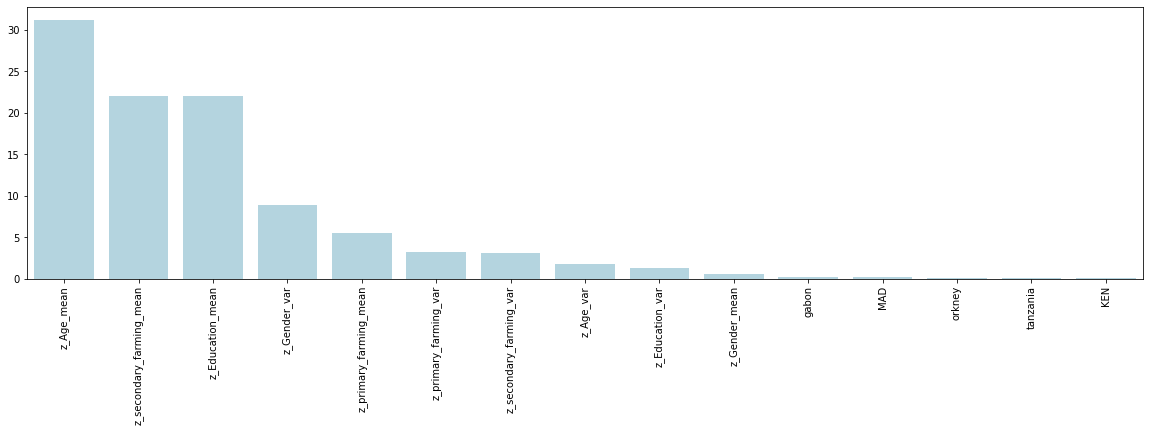

In [23]:
num_drivers = len(explanatory_var)
# Get a correlation between all of the dependent and independent variables.
corr_matrix = data[[response_var]+explanatory_var].apply(pd.to_numeric, errors = 'coerce').corr()
corr_Xs = corr_matrix.iloc[1:, 1:].copy()
corr_Xy = corr_matrix.iloc[1:, 0].copy()
# Create orthogonal predictors using eigenvectors and eigenvalues on the correlation matrix, creating a diagonal matrix
# of the square root of eigenvalues. This gets around the issue of multi-collinearity.
w_corr_Xs, v_corr_Xs = np.linalg.eig(corr_Xs)
diag_idx = np.diag_indices(len(corr_Xs))
diag = np.zeros((num_drivers, num_drivers), float)
diag[diag_idx] = w_corr_Xs
delta = np.sqrt(diag)
# Multiply the eigenvector matrix and its transposition. This allows us to treat X as the set of dependent variables, 
# regressing X onto matrix Z — itself the orthogonal counterpart of X having the least squared error. To get the partial 
# effect of each independent variable, we apply matrix multiplication to the inverse and correlation matricies.
coef_xz = v_corr_Xs @ delta @ v_corr_Xs.transpose()
coef_yz = np.linalg.inv(coef_xz) @ corr_Xy
# We then calculate the relative weight as the multiplication of the matrix in Step 2 and step 3. 
# The normalized version is then the percentage of r2 that these account for.
# Also, the sum of the squares of coef_yz above should add up to the total R2
r2 = sum(np.square(coef_yz))
raw_relative_weights = np.square(coef_xz) @ np.square(coef_yz)
normalized_relative_weights = (raw_relative_weights/r2)*100
idx = np.argsort(normalized_relative_weights)[::-1]
plt.figure(figsize=(20,5))
sns.barplot(x=corr_matrix.columns[1:][idx], y=np.sort(normalized_relative_weights)[::-1], color="lightblue")
plt.xticks(rotation=90)
plt.show()

## Scatter/regression plots for mean response_var grouped by explanatory variable

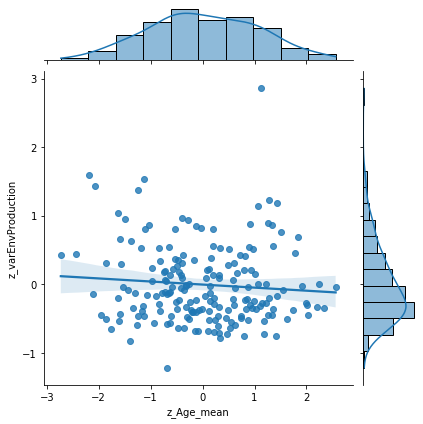

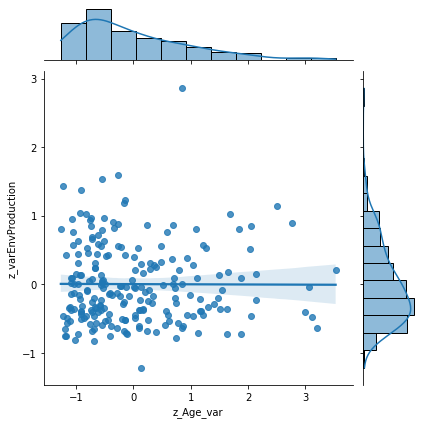

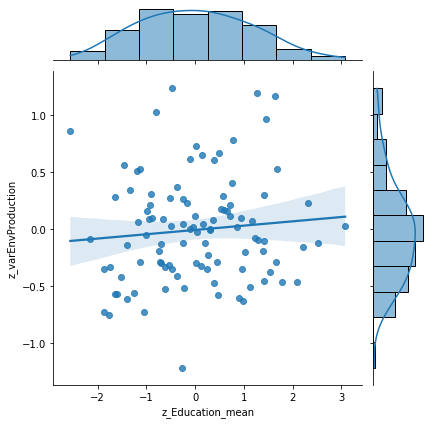

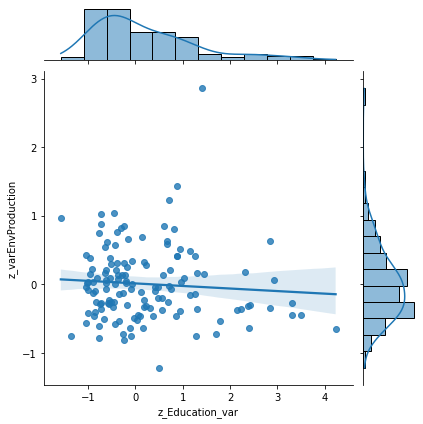

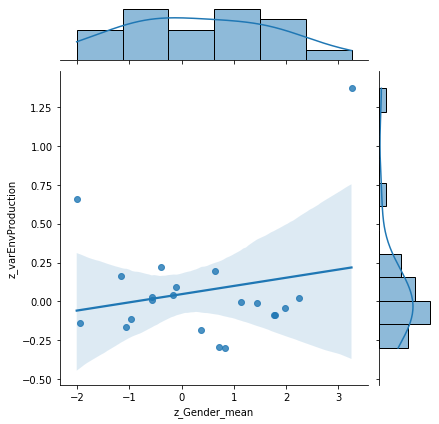

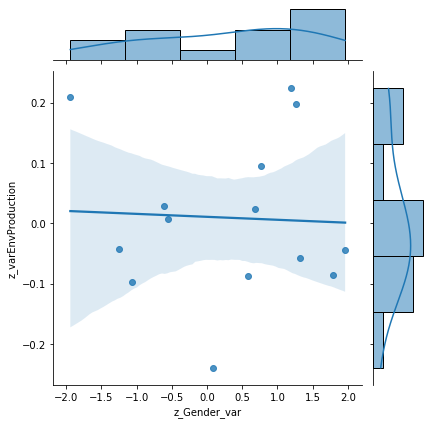

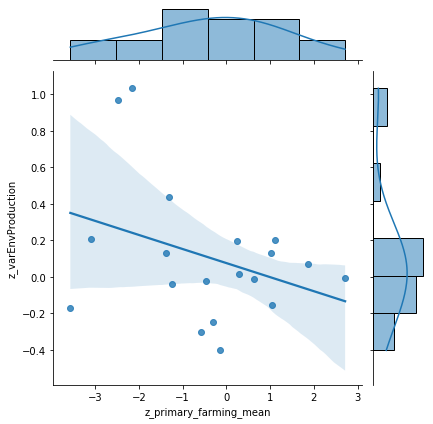

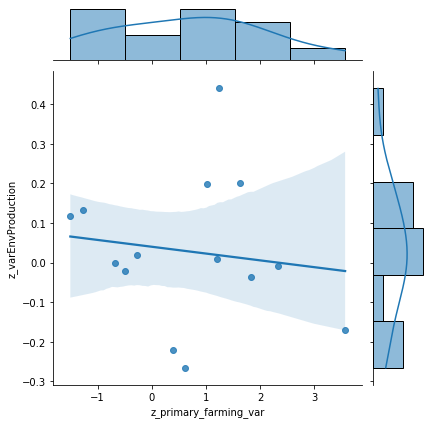

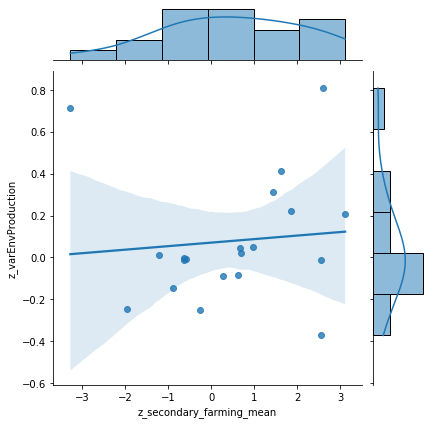

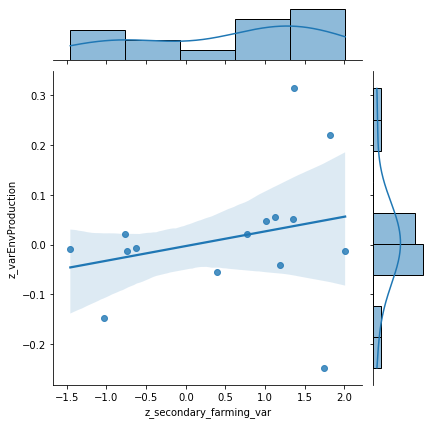

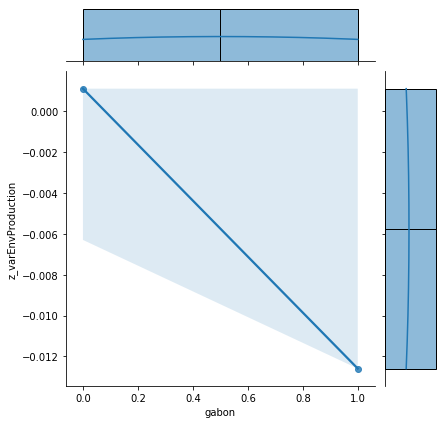

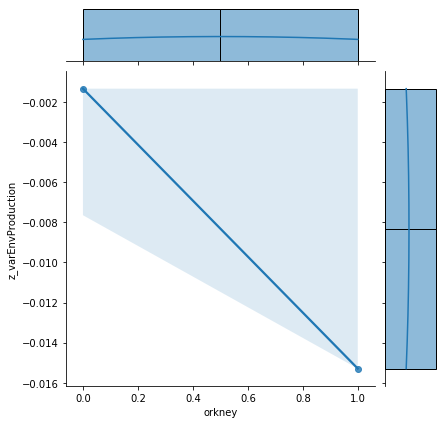

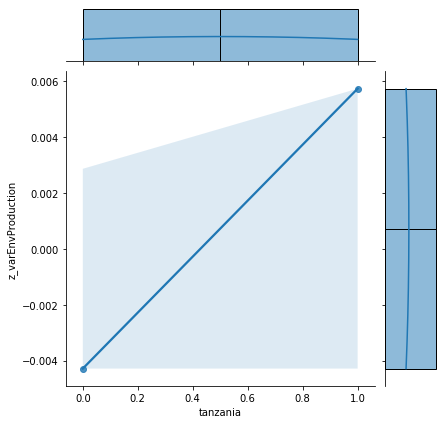

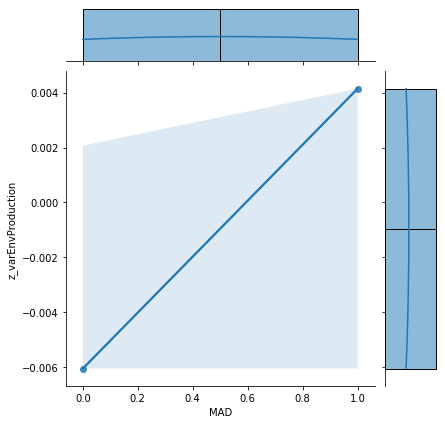

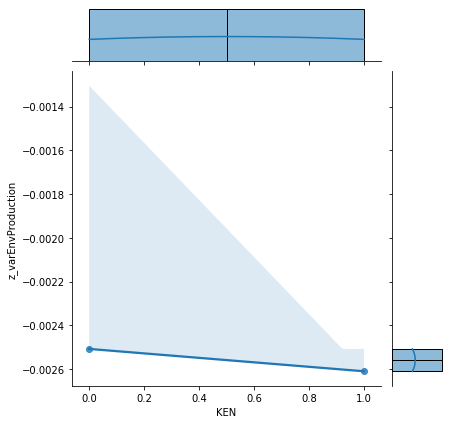

In [24]:
for var in explanatory_var:
    df = data[[var, response_var]].groupby(var).mean().reset_index()
    sns.jointplot(x=var, y=response_var, data=df, kind='reg')
    plt.show()

## Moving average and cubic regression plot for response_var against explanatory variable

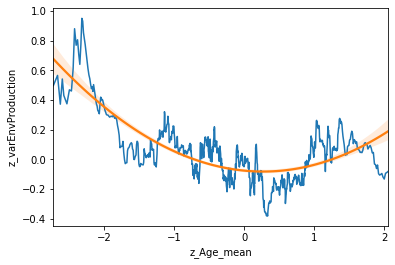

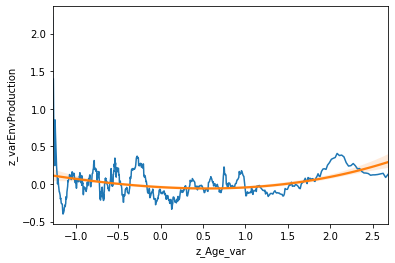

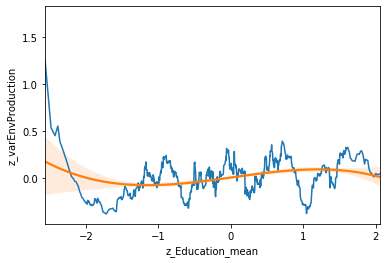

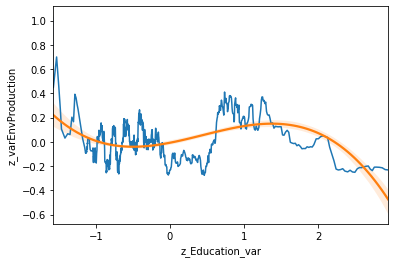

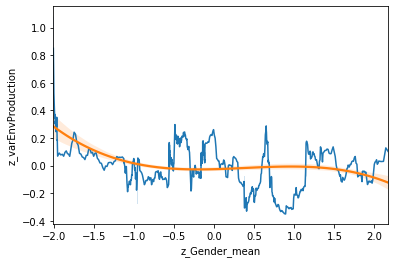

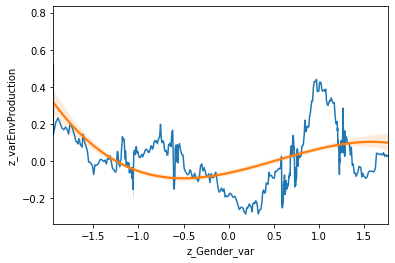

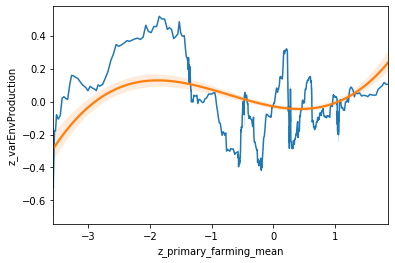

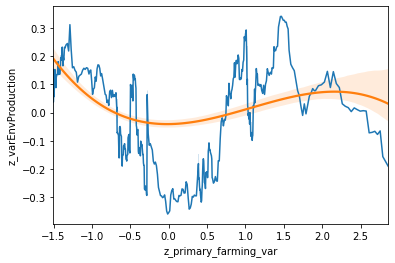

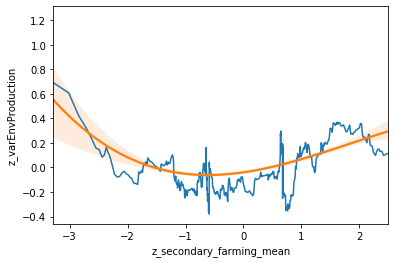

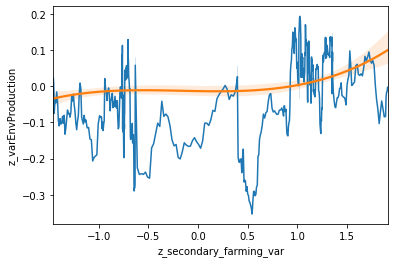

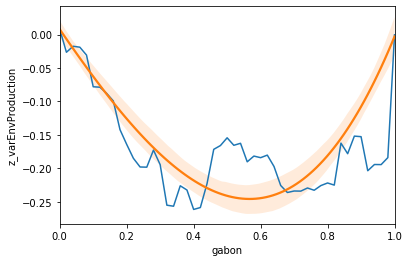

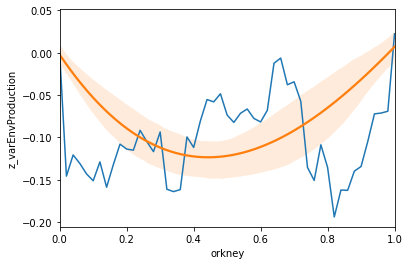

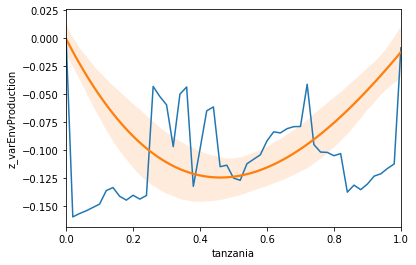

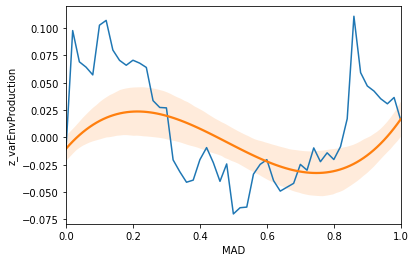

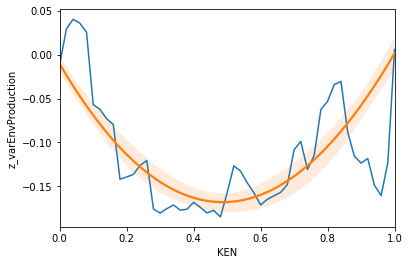

In [25]:
for var in explanatory_var:
    df = data[[var, response_var]].sort_values(by=var).rolling(window=50, min_periods=1).mean()
    sns.lineplot(x=var, y=response_var, data=df)
    sns.regplot(x=var, y=response_var, data=df, fit_reg=True, order=3, scatter=False)
    plt.show()

## Country-wise distributions of explanatory variable

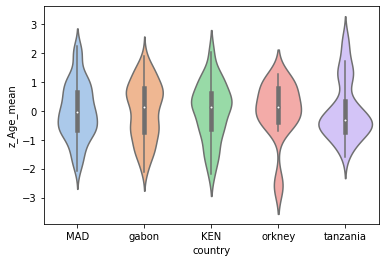

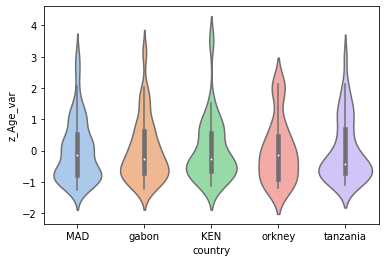

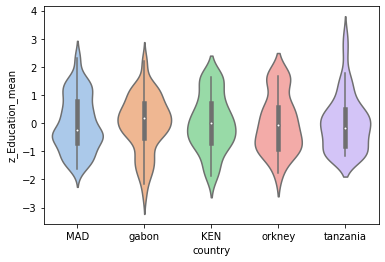

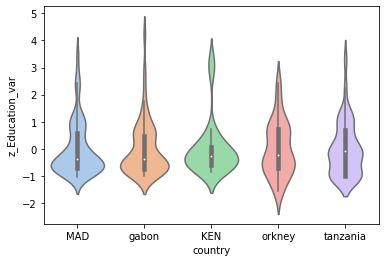

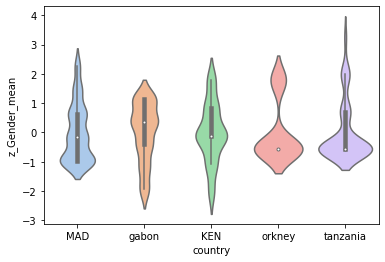

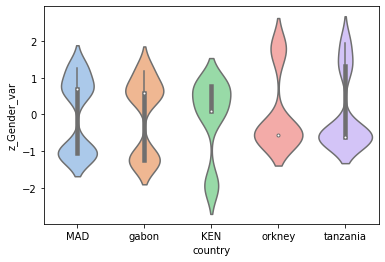

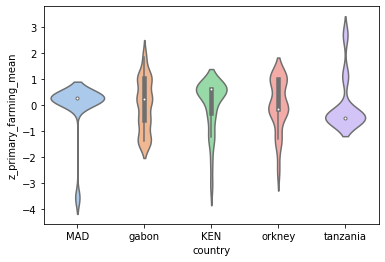

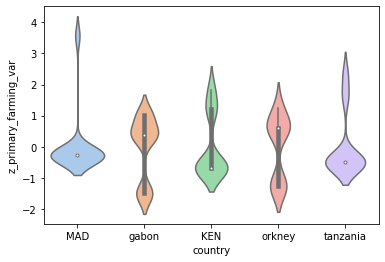

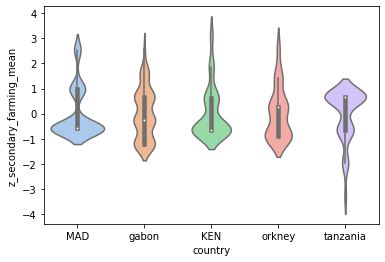

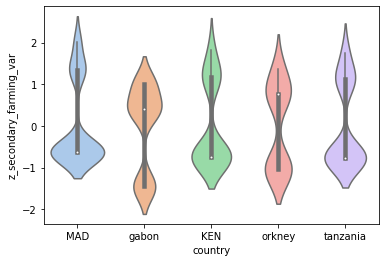

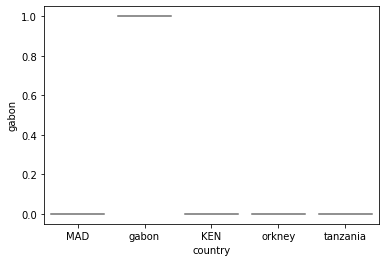

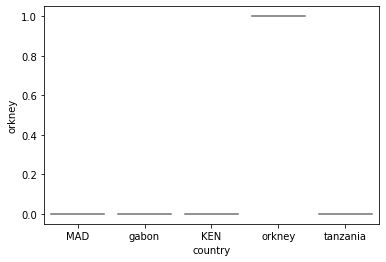

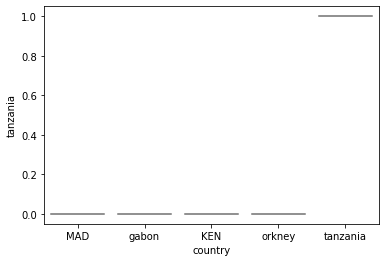

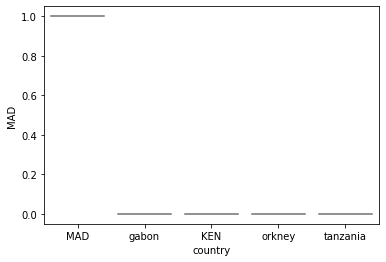

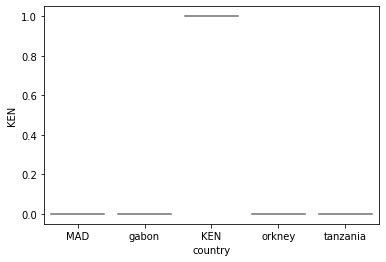

In [26]:
for var in explanatory_var:
    #df = data[[var, 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,7))
    sns.violinplot('country', var, data=data, palette='pastel')
    plt.show()

In [27]:
"""from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = StandardScaler().fit_transform(data[explanatory_var])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf.loc[:, 'principal component 1'],
           principalDf.loc[:, 'principal component 2'],
           c = data[response_var], s = 10, cmap='Blues')
ax.grid()"""

"from sklearn.preprocessing import StandardScaler\nfrom sklearn.decomposition import PCA\n\nx = StandardScaler().fit_transform(data[explanatory_var])\npca = PCA(n_components=2)\nprincipalComponents = pca.fit_transform(x)\nprincipalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])\n\nfig = plt.figure(figsize = (8,8))\nax = fig.add_subplot(1,1,1) \nax.set_xlabel('Principal Component 1', fontsize = 15)\nax.set_ylabel('Principal Component 2', fontsize = 15)\nax.set_title('2 component PCA', fontsize = 20)\nax.scatter(principalDf.loc[:, 'principal component 1'],\n           principalDf.loc[:, 'principal component 2'],\n           c = data[response_var], s = 10, cmap='Blues')\nax.grid()"

In [28]:
"""# calculating beta coefficients from coefficients
beta_coef = []
for var in results.params.index.values[1:]:
    beta_coef.append(results.params[var]*(data[var].std(ddof=0)/data[response_var].std(ddof=0)))
beta_coef = pd.DataFrame({'params':results.params.index.values[1:], 'coefs':beta_coef}).sort_values('coefs', ascending=False)
plt.figure(figsize=(20,5))
plt.bar('params', 'coefs', data=beta_coef)
plt.xticks(rotation=90)
plt.show()"""

"# calculating beta coefficients from coefficients\nbeta_coef = []\nfor var in results.params.index.values[1:]:\n    beta_coef.append(results.params[var]*(data[var].std(ddof=0)/data[response_var].std(ddof=0)))\nbeta_coef = pd.DataFrame({'params':results.params.index.values[1:], 'coefs':beta_coef}).sort_values('coefs', ascending=False)\nplt.figure(figsize=(20,5))\nplt.bar('params', 'coefs', data=beta_coef)\nplt.xticks(rotation=90)\nplt.show()"